In [1]:
! nvidia-smi

Mon Dec 15 21:12:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!wget https://github.com/pvateekul/digitalhealth-ai2025/raw/main/dataset/Ham10000_torch.zip

--2025-12-15 21:12:38--  https://github.com/pvateekul/digitalhealth-ai2025/raw/main/dataset/Ham10000_torch.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/pvateekul/digitalhealth-ai2025/main/dataset/Ham10000_torch.zip [following]
--2025-12-15 21:12:38--  https://media.githubusercontent.com/media/pvateekul/digitalhealth-ai2025/main/dataset/Ham10000_torch.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94841947 (90M) [application/zip]
Saving to: ‘Ham10000_torch.zip’

Ham10000_torch.zip  100%[===================>]  90.45M  53.9MB/s    in 1.7s    

2025-12-15 21:12:40 (53.9 M

In [3]:
!unzip -q -o 'Ham10000_torch.zip'

In [4]:
!pip install pytorch-lightning
!pip install torchinfo
!pip install -U scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 85.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [5]:
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image
from random import randint

# pytorch libraries
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [6]:
df=pd.read_csv('GroundTruth.csv')
print (df.head())
print (len(df))
print (df.columns)

   Unnamed: 0         image  MEL  NV  BCC  AKIEC  BKL  DF  VASC
0           0  ISIC_0024310    1   0    0      0    0   0     0
1           1  ISIC_0024306    0   1    0      0    0   0     0
2           2  ISIC_0024331    0   0    1      0    0   0     0
3           3  ISIC_0024329    0   0    0      1    0   0     0
4           4  ISIC_0024312    0   0    0      0    1   0     0
350
Index(['Unnamed: 0', 'image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF',
       'VASC'],
      dtype='object')


In [7]:
df['image']=df['image'].apply(lambda x: x+ '.jpg')
df = df.drop(columns=["Unnamed: 0"])

print (df.head())

              image  MEL  NV  BCC  AKIEC  BKL  DF  VASC
0  ISIC_0024310.jpg    1   0    0      0    0   0     0
1  ISIC_0024306.jpg    0   1    0      0    0   0     0
2  ISIC_0024331.jpg    0   0    1      0    0   0     0
3  ISIC_0024329.jpg    0   0    0      1    0   0     0
4  ISIC_0024312.jpg    0   0    0      0    1   0     0


In [8]:
lesion_type_dict = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic nevi',
    'BCC': 'Basal cell carcinoma',
    'AKIEC': 'Actinic keratoses',
    'BKL': 'Benign keratosis like lesions',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular lesions'
}

labels = list(df.columns[1:])
label_list=[]
for i in range (len(df)):
    row= list(df.iloc[i])[1:]
    index=np.argmax(row)
    label=lesion_type_dict[labels[index]]
    label_list.append(label)
df['label']= label_list
df=df.drop(labels, axis=1)
df['label_idx'] = pd.Categorical(df['label']).codes
print(df)

                image                          label  label_idx
0    ISIC_0024310.jpg                       Melanoma          5
1    ISIC_0024306.jpg               Melanocytic nevi          4
2    ISIC_0024331.jpg           Basal cell carcinoma          1
3    ISIC_0024329.jpg              Actinic keratoses          0
4    ISIC_0024312.jpg  Benign keratosis like lesions          2
..                ...                            ...        ...
345  ISIC_0025285.jpg           Basal cell carcinoma          1
346  ISIC_0025712.jpg              Actinic keratoses          0
347  ISIC_0024760.jpg  Benign keratosis like lesions          2
348  ISIC_0028926.jpg                 Dermatofibroma          3
349  ISIC_0027672.jpg               Vascular lesions          6

[350 rows x 3 columns]


In [9]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image      350 non-null    object
 1   label      350 non-null    object
 2   label_idx  350 non-null    int8  
dtypes: int8(1), object(2)
memory usage: 5.9+ KB


In [10]:
train_df, val_df, test_df = df[:210], df[210:280], df[280:350]

print('Data Len Train:', len(train_df), 'Val:', len(val_df), 'Test:', len(test_df))

Data Len Train: 210 Val: 70 Test: 70


In [11]:
max_size=100 # set maximum number of samples for each class
samples=[]
group=train_df.groupby('label')
for label in train_df['label'].unique():
    Lgroup=group.get_group(label)
    count=int(Lgroup['label'].value_counts())
    if count>=max_size:
        sample=Lgroup.sample(max_size, axis=0)
    else:
        sample=Lgroup.sample(frac=1, axis=0)
    samples.append(sample)
train_df=pd.concat(samples, axis=0).reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print(train_df['label'].value_counts())

label
Melanoma                         30
Melanocytic nevi                 30
Basal cell carcinoma             30
Actinic keratoses                30
Benign keratosis like lesions    30
Dermatofibroma                   30
Vascular lesions                 30
Name: count, dtype: int64


/tmp/ipython-input-4034613076.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  count=int(Lgroup['label'].value_counts())
/tmp/ipython-input-4034613076.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  count=int(Lgroup['label'].value_counts())
/tmp/ipython-input-4034613076.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  count=int(Lgroup['label'].value_counts())
/tmp/ipython-input-4034613076.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  count=int(Lgroup['label'].value_counts())
/tmp/ipython-input-4034613076.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a Typ

In [12]:
train_transform = transforms.Compose(
    [transforms.Resize((230,230)),
        transforms.RandomRotation(30,),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]) #nomalize imagenet pretrain
    ])

val_transform = transforms.Compose(
    [transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ])

In [13]:
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(os.path.join('images', self.df['image'][index]))
        y = torch.tensor(int(self.df['label_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [14]:
BATCH_SIZE = 10
NUM_WORKERS = 2

# Define the training,val,test sets using the tables and using our defined transitions
train_set = HAM10000(train_df, transform=train_transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

val_set = HAM10000(val_df, transform=val_transform)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

test_set = HAM10000(test_df, transform=val_transform)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print('Data Len Train:', len(train_set), 'Val:', len(val_set), 'Test:', len(test_set))

Data Len Train: 210 Val: 70 Test: 70


In [15]:
from torchmetrics.classification import Accuracy
import pytorch_lightning as pl

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [16]:
class LitEfficientNetV2(pl.LightningModule):
    def __init__(self, num_classes=10, learning_rate=1e-3):
        super().__init__()
        # Load EfficientNetV2 model from torchvision
        self.model = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
        # Replace the classifier with a custom layer for our task
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.learning_rate = learning_rate
        self.train_metrics = []
        self.val_metrics = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.accuracy(logits.argmax(dim=1), y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.accuracy(logits.argmax(dim=1), y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)

    def on_train_epoch_end(self):
        # Collect epoch metrics

        train_loss = self.trainer.callback_metrics["train_loss"]
        train_acc = self.trainer.callback_metrics["train_acc"]
        self.train_metrics.append(
            {
                "epoch": self.current_epoch,
                "train_loss": train_loss.item(),
                "train_acc": train_acc.item(),
            }
        )

    def on_validation_epoch_end(self):
        # Update validation metrics
        val_loss = self.trainer.callback_metrics["val_loss"]
        val_acc = self.trainer.callback_metrics["val_acc"]
        self.val_metrics.append(
            {
                "val_loss": val_loss.item(),
                "val_acc": val_acc.item(),
            }
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

net = LitEfficientNetV2().to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 113MB/s]


In [17]:
from pytorch_lightning.callbacks import ModelCheckpoint

In [18]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",       # Monitor validation accuracy
    mode="max",              # Save the model with the highest accuracy
    save_top_k=1,            # Save only the best model
    filename="efficientnetv2-best-{epoch:02d}-{val_acc:.4f}",  # File name format
    verbose=True             # Print messages when saving
)

In [19]:
trainer = pl.Trainer(max_epochs=5, callbacks=[checkpoint_callback])
trainer.fit(net, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ EfficientNet       │ 20.2 M │ train │     0 │
│ 1 │ criterion │ CrossEntropyLoss   │      0 │ train │     0 │
│ 2 │ accuracy  │ MulticlassAccuracy │      0 │ train │     0 │
└───┴───────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 20.2 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 20.2 M                                                                                               
Total estimated model params size (MB): 80                                                                         
Modules in train mode: 716                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:317: The number of training batches 
(21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 21: 'val_acc' reached 0.54286 (best 0.54286), saving model to '/content/lightning_logs/version_0/checkpoints/efficientnetv2-best-epoch=00-val_acc=0.5429.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 42: 'val_acc' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 63: 'val_acc' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 84: 'val_acc' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 105: 'val_acc' reached 0.58571 (best 0.58571), saving model to '/content/lightning_logs/version_0/checkpoints/efficientnetv2-best-epoch=04-val_acc=0.5857.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


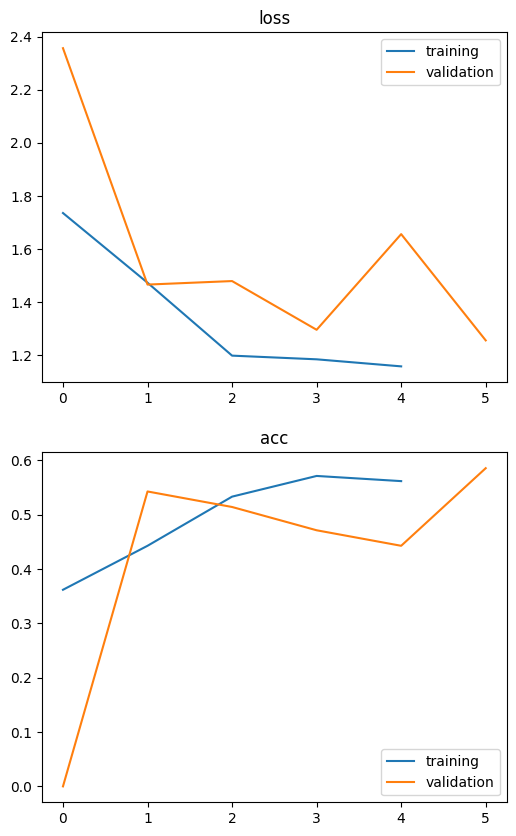

In [20]:
fig, axs = plt.subplots(2, figsize= (6,10))
# loss
axs[0].plot([entry['train_loss'] for entry in net.train_metrics], label = 'training')
axs[0].plot([entry['val_loss'] for entry in net.val_metrics], label = 'validation')
axs[0].set_title("loss")
axs[0].legend()
# acc
axs[1].plot([entry['train_acc'] for entry in net.train_metrics], label = 'training')
axs[1].plot([entry['val_acc'] for entry in net.val_metrics], label = 'validation')
axs[1].set_title("acc")
axs[1].legend()

In [21]:
from typing import NewType
print(f"Best model saved at: {checkpoint_callback.best_model_path}")

best_model_path = checkpoint_callback.best_model_path
best_model = LitEfficientNetV2.load_from_checkpoint(best_model_path).to(device)

# Use the best model for inference
best_model.eval()
best_model.freeze()

Best model saved at: /content/lightning_logs/version_0/checkpoints/efficientnetv2-best-epoch=04-val_acc=0.5857.ckpt


In [25]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

criterion = nn.CrossEntropyLoss()
print('testing ...')
y_predict = list()
y_labels = list()
test_loss = 0.0
n = 0
with torch.no_grad():
    for data in tqdm(test_loader):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
        # To get probabilities, you can run a softmax on outputs
        y_probs = torch.nn.functional.softmax(outputs, dim=1)
        y_probs = list(y_probs.cpu().numpy())
        n+=1

    # print statistics
    test_loss /= n
    print(f"testing loss: {test_loss:.4}" )


    class_names = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]

    report = classification_report(y_labels, y_predict, target_names=class_names, digits = 4)
    M = confusion_matrix(y_labels, y_predict)
    print(report)
    disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=class_names)

testing ...


100%|██████████| 7/7 [00:01<00:00,  4.72it/s]

testing loss: 1.067
              precision    recall  f1-score   support

         MEL     0.3077    0.4000    0.3478        10
          NV     1.0000    0.4000    0.5714        10
         BCC     0.0000    0.0000    0.0000        10
       AKIEC     0.7500    0.6000    0.6667        10
         BKL     0.6154    0.8000    0.6957        10
          DF     0.2353    0.4000    0.2963        10
        VASC     0.6667    1.0000    0.8000        10

    accuracy                         0.5143        70
   macro avg     0.5107    0.5143    0.4826        70
weighted avg     0.5107    0.5143    0.4826        70




/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


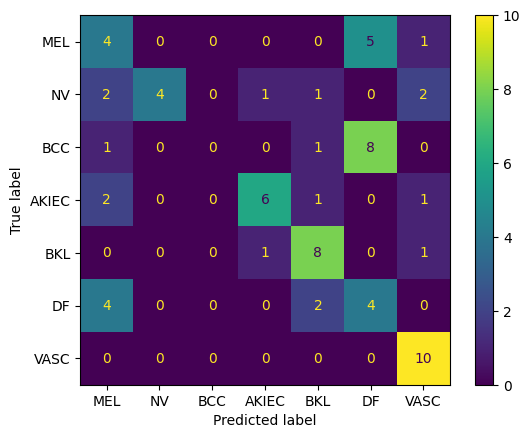

In [26]:
disp.plot()
plt.show()

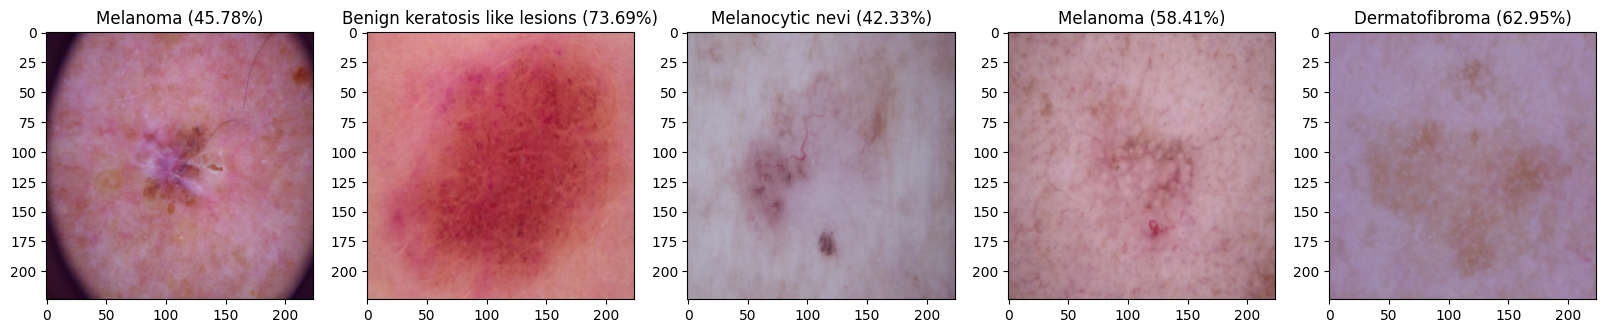

In [27]:
plt.figure(figsize=(20,5))
dataiter = iter(test_loader)
inputs, labels = next(dataiter)
with torch.no_grad():

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        y_labels = list(labels.cpu().numpy())
        y_predict = list(outputs.argmax(dim=1).cpu().numpy())
        # To get probabilities, you can run a softmax on outputs
        y_probs = torch.nn.functional.softmax(outputs, dim=1)
        y_probs = list(y_probs.cpu().numpy())

# We selected a sample from the first five images for visualization
for i in range(5):
    plt.subplot(1,5,i+1)
    img = inputs[i]
    img = img*torch.tensor([0.267, 0.256, 0.276]).mean() + torch.tensor([0.507, 0.487, 0.441]).mean()     # unnormalize
    npimg = img.cpu().numpy()
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    most_prob = np.argmax(y_probs[i])
    label = df['label'][most_prob]
    prob = y_probs[i][most_prob]
    plt.title(f"{label} ({prob*100:.2f}%)")